In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = 'jax'

import tensorflow.keras as keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt



2025-03-30 15:15:39.637914: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 15:15:39.648902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743344139.659110    4587 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743344139.662157    4587 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743344139.670250    4587 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} and y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} and y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) and y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) and y_test shape: (10000, 1)


In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim
]
transformer_layers = 8
mlp_head_units = [
    2048, 1024
]


In [4]:
data_augmentation = keras.Sequential([
    layers.Normalization(),
    layers.Resizing(image_size, image_size),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=0.02),
    layers.RandomZoom(height_factor=0.02, width_factor=0.02),
], name="data_augmentation")
data_augmentation.layers[0].adapt(x_train)

2025-03-30 15:15:42.460911: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [6]:
class Patches(layers.Layer):
    def __init__(self, num_patches):
        super().__init__()
        self.patch_size = num_patches

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            )
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Image size: 72 X 72
Patch size: 6 X 6
Number of patches per images: 144
Elements per patch: 108


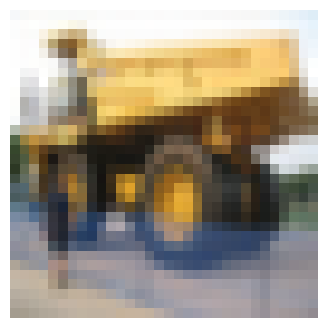

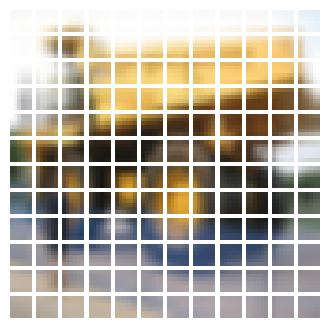

In [7]:
plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis('off')

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]),
    size=(image_size, image_size),
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Number of patches per images: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis('off')


In [8]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.postition_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        postitons = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projection_patches = self.projection(patch)
        encoded = projection_patches + self.postition_embedding(postitons)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config




In [9]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)

    augmentation = data_augmentation(inputs)

    patches = Patches(patch_size)(augmentation)

    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim,
            dropout=0.1
        ) (x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model




Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.2657 - loss: 2.7362 - top-5-accuracy: 0.7371 - val_accuracy: 0.4780 - val_loss: 1.4426 - val_top-5-accuracy: 0.9262
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.4529 - loss: 1.5169 - top-5-accuracy: 0.9069 - val_accuracy: 0.5656 - val_loss: 1.2321 - val_top-5-accuracy: 0.9452
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.5168 - loss: 1.3418 - top-5-accuracy: 0.9356 - val_accuracy: 0.6020 - val_loss: 1.1353 - val_top-5-accuracy: 0.9600
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.5617 - loss: 1.2275 - top-5-accuracy: 0.9489 - val_accuracy: 0.6258 - val_loss: 1.0521 - val_top-5-accuracy: 0.9676
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.5960 - loss: 1.1444 - top-5-accuracy: 0.9571 - val_accuracy: 0.6678 - val_loss: 0.9590 - val_top-5-accuracy: 0.9736
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.6179 - loss: 1.075

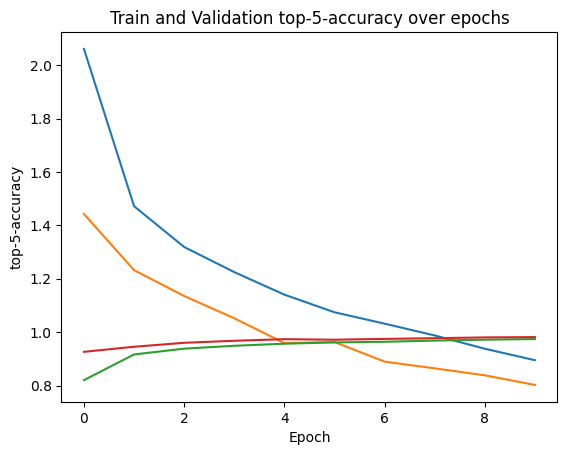

In [10]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "./tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Accuracy: {accuracy}")
    print(f"Top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

vit_model = create_vit_classifier()
history = run_experiment(vit_model)#

def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epoch")
    plt.ylabel(item)
    plt.title("Train and Validation {} over epochs".format(item))

plot_history("loss")
plot_history("top-5-accuracy")